In [1]:
import numpy as np 
import pandas as pd
import scanpy as sc
import seaborn as sns

In [2]:
def saveWithPickle(obj, PATH_out, filename="saveWithPickle"):
    import pickle
    with open(f'{PATH_out}/{filename}.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def loadFromPickle(dir_pickle):
    import pickle
    with open(dir_pickle, 'rb') as handle:
        unserialized_pickle = pickle.load(handle)
    return unserialized_pickle

In [ ]:
""" 
Mast cells
    De novo
    https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2023.1189520/full (Figure 2)
        TPSB2, TPSAB1, MS4A2, CPA3
    
DC 
    https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2021.711329/full
        cDC1:
            pass 
        cDC2:
            FCER1A, CD1C, CLEC10A, 
    https://www.nature.com/articles/s41556-021-00681-2#Fig1  ('The accurate identification of all six APC populations was confirmed  ...')
        DC:
            CD1C, CLEC9A, 
        pDC:
            AXL, SIGLEC6
    
Monocytes and Macrophages
    https://pmc.ncbi.nlm.nih.gov/articles/PMC4201108/
        cMonocytes:
            (+) CD14, CCR2,
            (-) CD16, CX3CR1
        intermediate monocytes:
            (+) CD14, CD16, CX3CR1
            (-) CCR2
        ncMonocytes:
            (+) CD14, CD16, CX3CR1
            
    - 
        Monocyte enriched: S100A6, S100A8
             
    https://www.nature.com/articles/s41556-021-00681-2 
        Monocytes:
            CD14, FCGR3A (CD16), 
            
    -
        Macrophage: C1QA, C1QB, C1QC
"""

In [346]:
Myeloid_markers = { 'Monocytes' : ['S100A6', 'S100A8', 'CD14', 'CCR2', 'FCGR3A', 'CX3CR1'], 
                   'Macrophage' : ['C1QA', 'C1QB', 'C1QC'],
                   'Mast' :         ['MS4A2', 'TPSAB1', 'TPSB2', 'CPA3' ], 
                   'DC' : ['CD1C', 'CLEC9A', 'CLEC10A', 'LAMP3'],
                   'pDC' : ['CLEC4C', 'GZMB', "IL3RA", ],
                   'Neutrophils' : ['FPR1', 'CSF3R', 'FCGR3B', 'NAMPT', 'MNDA', 'FUT4', 'G0S2'],
                   }

pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/TME_annot_temp_files/10x_neutrophil.blood.csv')

List    Name
0   Neutrophil Markers   CSF3R
1   Neutrophil Markers    FPR1
2   Neutrophil Markers  FCGR3B
3   Neutrophil Markers   NAMPT
4   Neutrophil Markers    MNDA
5       T Cell Markers    CD3D
6       T Cell Markers    CD3E
7       T Cell Markers     CD4
8       B Cell Markers   CD79A
9       B Cell Markers   CD79B
10    Monocyte Markers    CD14

## Load data

In [14]:
adata_chen_TME = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/TME_annot_temp_files/Chen.MSI.preprocessed.NanoMnT.nonTumor.preAnnot.h5ad')

In [8]:
dict_Identifier_to_lvl_1_CellType = dict()
dict_Identifier_to_lvl_2_CellType = dict()

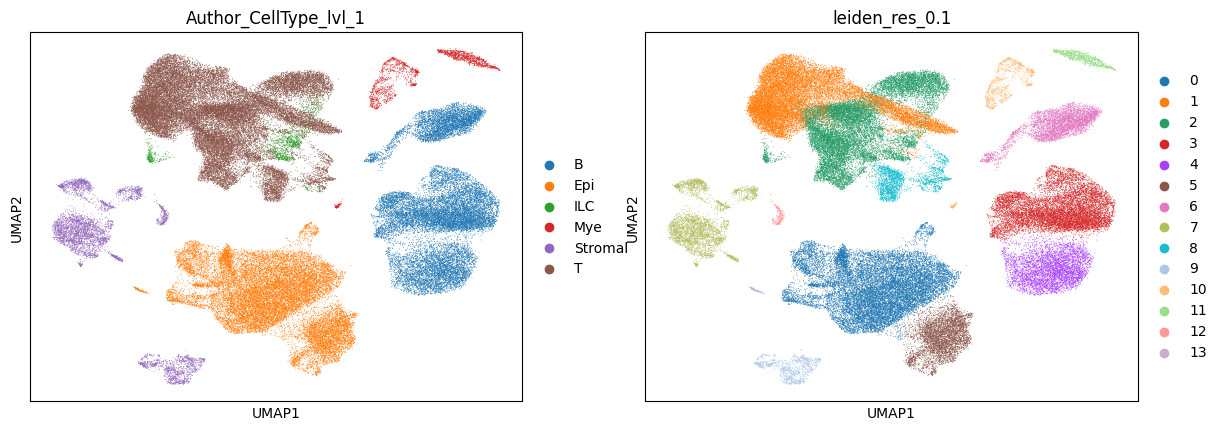

In [17]:
sc.pl.umap(adata_chen_TME, color=['Author_CellType_lvl_1', 'leiden_res_0.1'])

In [487]:
chen_patient_metadata = pd.read_csv('/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.patient_meta.csv',)

dict_PatientID_to_TumorLocation = { list(tup)[1] : list(tup)[5] for tup in chen_patient_metadata.itertuples() }

## Myeloid cells

In [19]:
adata_chen_mye = adata_chen_TME[adata_chen_TME.obs['leiden_res_0.1'].isin(['10', '11'])].copy()
adata_chen_mye = adata_chen_mye.raw.to_adata()

In [21]:
sc.pp.normalize_total(adata_chen_mye)
sc.pp.log1p(adata_chen_mye)
sc.pp.highly_variable_genes(adata_chen_mye, n_top_genes=2000, batch_key="SampleID")

adata_chen_mye.raw = adata_chen_mye.copy()
adata_chen_mye = adata_chen_mye[:, adata_chen_mye.var.highly_variable]

sc.pp.scale(adata_chen_mye, max_value=10)
sc.tl.pca(adata_chen_mye, svd_solver="arpack")

sc.pp.neighbors(adata_chen_mye, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_chen_mye, random_state=42)

2024-12-22 14:18:47.954822: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-22 14:18:47.955990: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-22 14:18:47.959888: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-22 14:18:47.971605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-22 14:18:47.989666: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [22]:
sc.tl.leiden(adata_chen_mye, resolution=0.2, key_added='sub1_leiden')

/tmp/ipykernel_207941/3228160893.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_chen_mye, resolution=0.2, key_added='sub1_leiden')


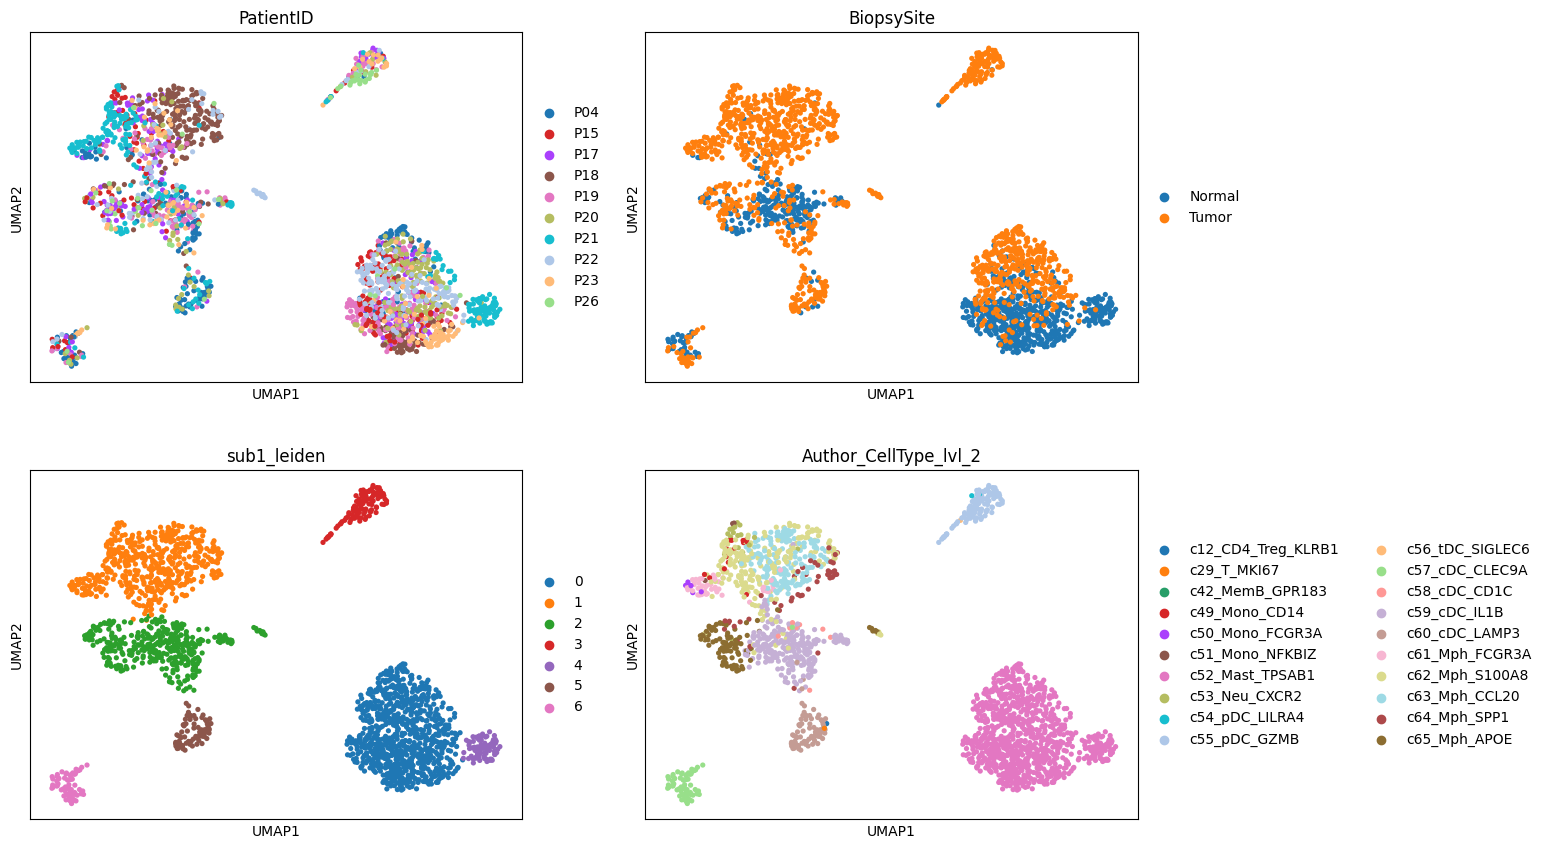

In [24]:
sc.pl.umap(adata_chen_mye, color=['PatientID', 'BiopsySite', 'sub1_leiden', 'Author_CellType_lvl_2'], ncols=2)

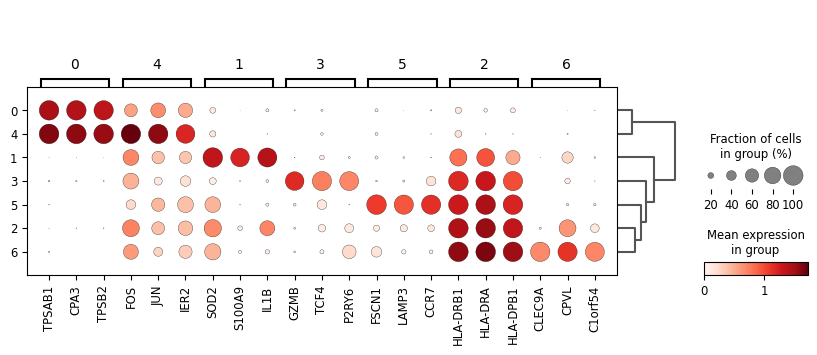

In [284]:
sc.tl.rank_genes_groups(adata_chen_mye, groupby='sub1_leiden', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata_chen_mye, n_genes=3, groupby='sub1_leiden')

### leiden 0, 4 → Mast

In [175]:
for tup in adata_chen_mye[adata_chen_mye.obs['sub1_leiden'].isin(['0', '4'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Mast'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'Mast'

### leiden 1, 2 → Mixture of Monocyte, Macrophage and DC 

In [197]:
adata_chen_mye_l1 = adata_chen_mye[adata_chen_mye.obs['sub1_leiden'].isin(['1', '2'])].copy()
adata_chen_mye_l1 = adata_chen_mye_l1.raw.to_adata()

temp = list()
for SampleID, edf in adata_chen_mye_l1.obs.groupby('SampleID'):
    if len(edf) <= 1:
        print(SampleID, len(edf))
        temp.append( SampleID )
        dict_Identifier_to_lvl_1_CellType[edf.iloc[0].Identifier] = 'N/A'
        dict_Identifier_to_lvl_2_CellType[edf.iloc[0].Identifier] = 'N/A'

adata_chen_mye_l1 = adata_chen_mye_l1[~(adata_chen_mye_l1.obs['SampleID'].isin(temp))].copy()

sc.pp.normalize_total(adata_chen_mye_l1)
sc.pp.log1p(adata_chen_mye_l1)
sc.pp.highly_variable_genes(adata_chen_mye_l1, n_top_genes=500, batch_key="SampleID")

adata_chen_mye_l1.raw = adata_chen_mye_l1.copy()
adata_chen_mye_l1 = adata_chen_mye_l1[:, adata_chen_mye_l1.var.highly_variable]

sc.pp.scale(adata_chen_mye_l1, max_value=10)
sc.tl.pca(adata_chen_mye_l1, svd_solver="arpack")

sc.pp.neighbors(adata_chen_mye_l1, n_neighbors=20, n_pcs=40)
sc.tl.umap(adata_chen_mye_l1, random_state=42)

/tmp/ipykernel_207941/1173884552.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for SampleID, edf in adata_chen_mye_l1.obs.groupby('SampleID'):
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


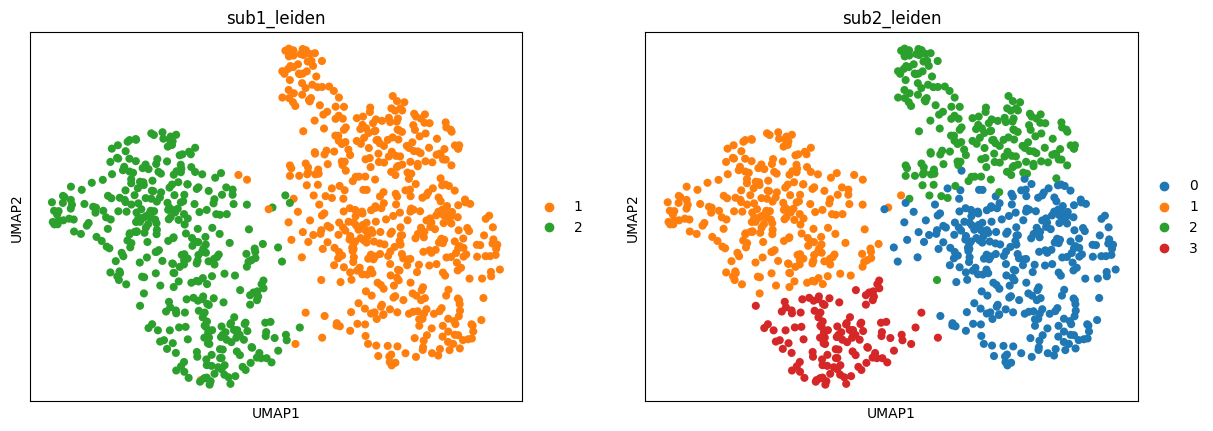

In [313]:
sc.tl.leiden(adata_chen_mye_l1, resolution=0.5, key_added='sub2_leiden')
sc.pl.umap(adata_chen_mye_l1, color=['sub1_leiden', 'sub2_leiden', ])

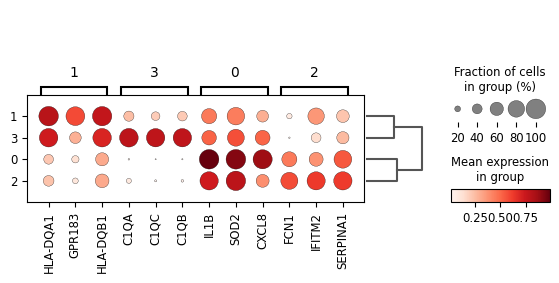

In [199]:
sc.tl.rank_genes_groups(adata_chen_mye_l1, groupby='sub2_leiden', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata_chen_mye_l1, n_genes=3, groupby='sub2_leiden')

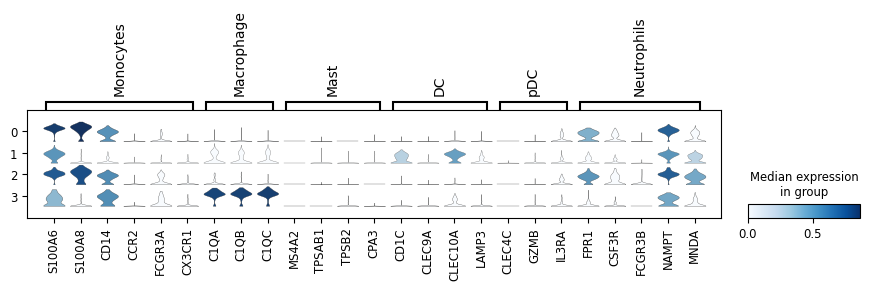

In [333]:
sc.pl.stacked_violin(adata_chen_mye_l1, var_names=Myeloid_markers, 
                     groupby='sub2_leiden')

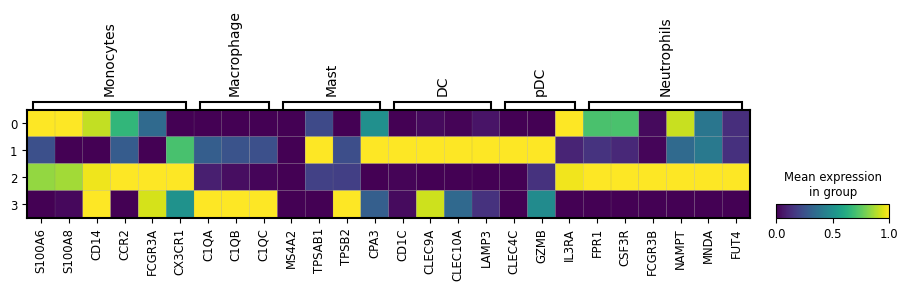

In [336]:
sc.pl.matrixplot(adata_chen_mye_l1, var_names=Myeloid_markers, standard_scale='var',
                     groupby='sub2_leiden')

In [269]:
for tup in adata_chen_mye_l1[adata_chen_mye_l1.obs['sub2_leiden'].isin(['0', '2'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Monocyte/Macrophage'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'Monocyte'
    
for tup in adata_chen_mye_l1[adata_chen_mye_l1.obs['sub2_leiden'].isin(['1'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Dendritic'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'cDC'
    
for tup in adata_chen_mye_l1[adata_chen_mye_l1.obs['sub2_leiden'].isin(['3'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Monocyte/Macrophage'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'Macrophage'

### leiden 3 → pDC 

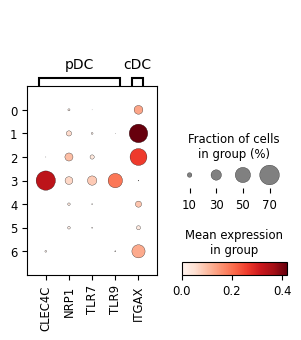

In [279]:
sc.pl.dotplot(adata_chen_mye, var_names={ 'pDC' : ['CLEC4C', 'NRP1', 'TLR7', 'TLR9'], 'cDC' : ['ITGAX'], }, groupby='sub1_leiden')

In [280]:
for tup in adata_chen_mye[adata_chen_mye.obs['sub1_leiden'].isin(['3'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Dendritic'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'pDC'

### leiden 5, 6 → cDC 

In [271]:
for tup in adata_chen_mye[adata_chen_mye.obs['sub1_leiden'].isin(['5', '6'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Dendritic'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'cDC'

### Label results

In [281]:
adata_chen_mye.obs['Manual_CellType_lvl_1'] = [ dict_Identifier_to_lvl_1_CellType[Identifier] for Identifier in adata_chen_mye.obs['Identifier'] ]
adata_chen_mye.obs['Manual_CellType_lvl_2'] = [ dict_Identifier_to_lvl_2_CellType[Identifier] for Identifier in adata_chen_mye.obs['Identifier'] ]

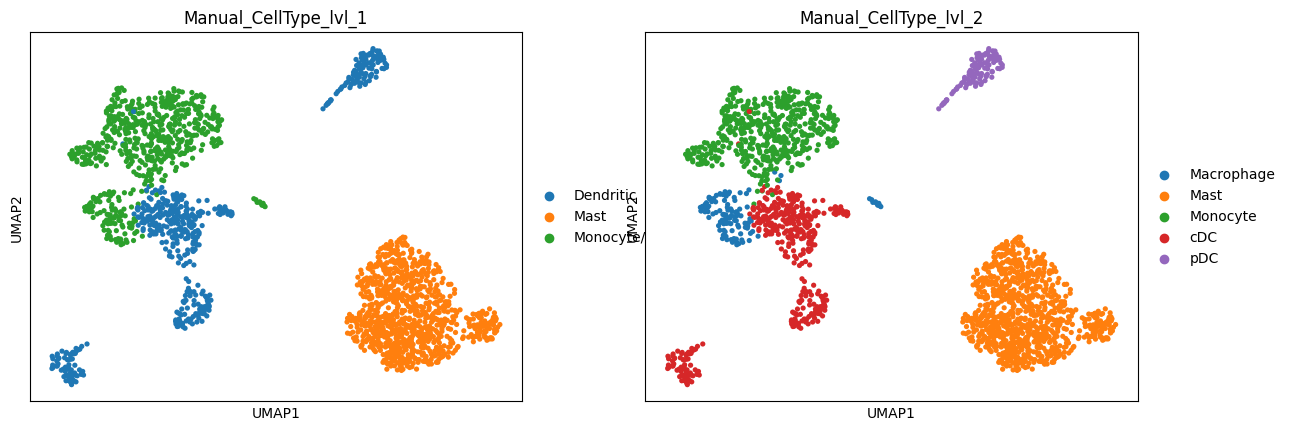

In [283]:
sc.pl.umap(adata_chen_mye, color=['Manual_CellType_lvl_1', 'Manual_CellType_lvl_2'])

### Inspect results

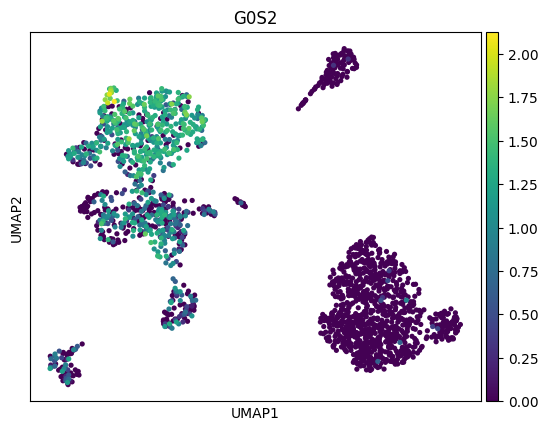

In [350]:
sc.pl.umap(adata_chen_mye, color=['G0S2'])

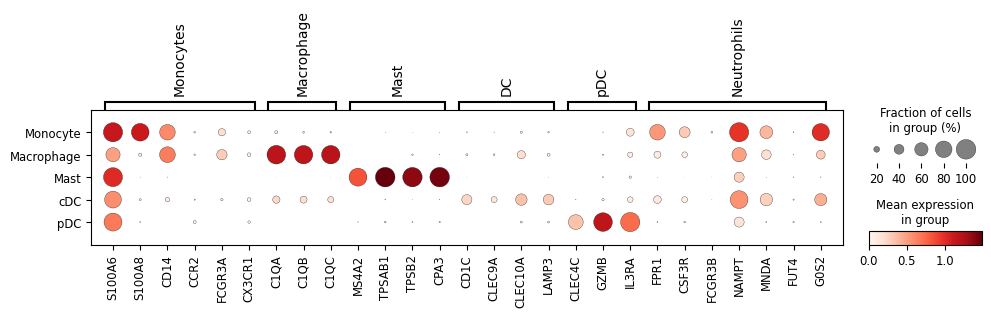

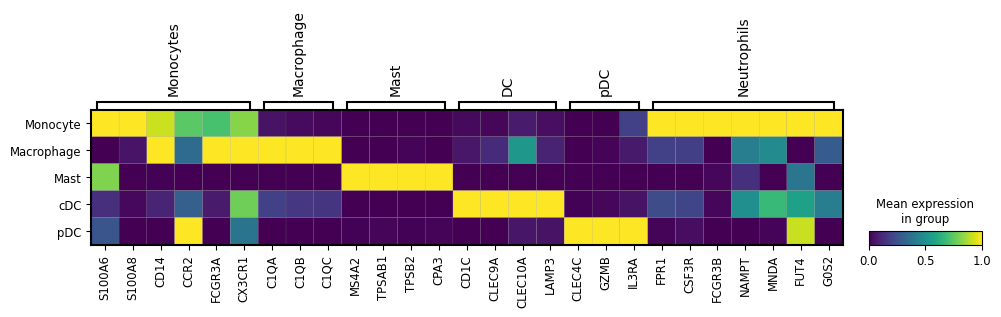

In [351]:

sc.pl.dotplot(adata_chen_mye, var_names=Myeloid_markers, groupby='Manual_CellType_lvl_2', categories_order=['Monocyte', 'Macrophage', 'Mast', 'cDC', 'pDC'])
sc.pl.matrixplot(adata_chen_mye, var_names=Myeloid_markers, groupby='Manual_CellType_lvl_2', standard_scale='var', categories_order=['Monocyte', 'Macrophage', 'Mast', 'cDC', 'pDC'])

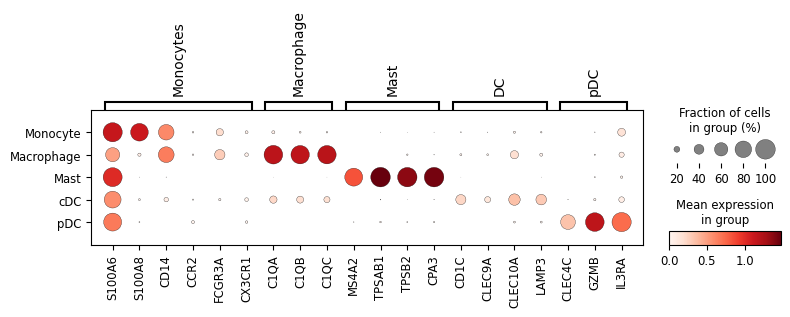

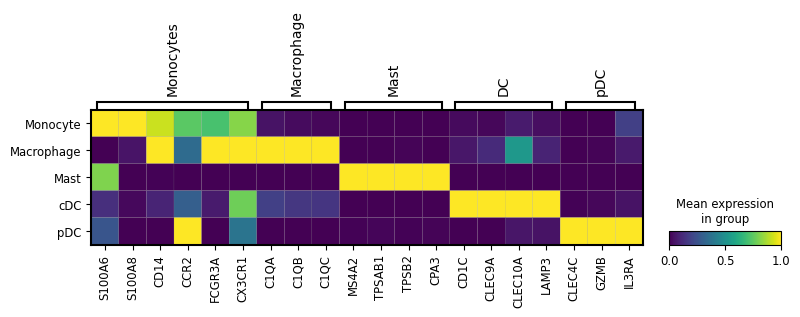

In [319]:
sc.pl.dotplot(adata_chen_mye, var_names=Myeloid_markers, groupby='Manual_CellType_lvl_2', categories_order=['Monocyte', 'Macrophage', 'Mast', 'cDC', 'pDC'])
sc.pl.matrixplot(adata_chen_mye, var_names=Myeloid_markers, groupby='Manual_CellType_lvl_2', standard_scale='var', categories_order=['Monocyte', 'Macrophage', 'Mast', 'cDC', 'pDC'])

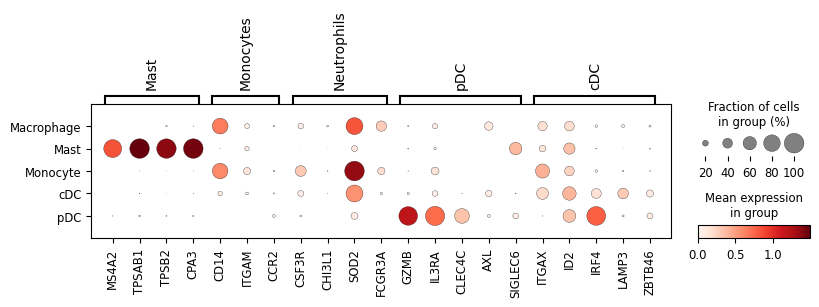

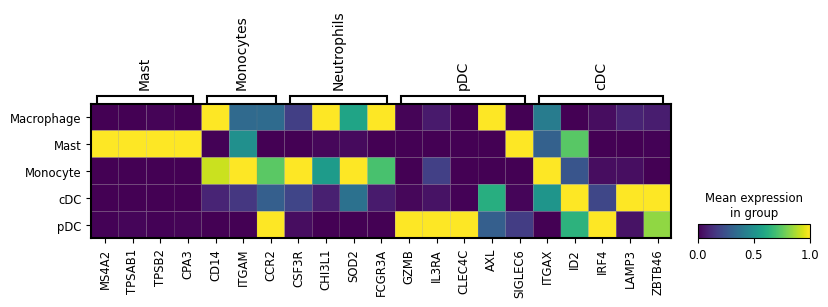

In [289]:
Myeloid_markers = { 
                   'Mast' :         ['MS4A2', 'TPSAB1', 'TPSB2', 'CPA3' ], 
                   'Monocytes' :    ['CD14', 'ITGAM', 'CCR2'],
                   'Neutrophils' :  ['CSF3R', 'CHI3L1', 'SOD2', 'FCGR3A'], 
                   'pDC' :          ["GZMB", "IL3RA", 'CLEC4C', 'AXL', 'SIGLEC6'],
                   'cDC' :          ['ITGAX', 'ID2', 'IRF4', 'LAMP3', 'ZBTB46'],
                   }

APC_markers = {
                   'MHC I' : ['HLA-A', 'HLA-B', 'HLA-C', 'B2M', ],
                   'MHC II': ['HLA-DRA', 'HLA-DRB1'],
                   }

sc.pl.dotplot(adata_chen_mye, var_names=Myeloid_markers, groupby='Manual_CellType_lvl_2',)
sc.pl.matrixplot(adata_chen_mye, var_names=Myeloid_markers, groupby='Manual_CellType_lvl_2', standard_scale='var')

In [341]:
temp = list()
for Identifier in adata_chen_TME.obs['Identifier']:
    try:
        temp.append( dict_Identifier_to_lvl_1_CellType[Identifier] )
    except KeyError:
        temp.append( 'N/A' )

adata_chen_TME.obs['Manual_CellType_lvl_1'] = temp

temp = list()
for Identifier in adata_chen_TME.obs['Identifier']:
    try:
        temp.append( dict_Identifier_to_lvl_2_CellType[Identifier] )
    except KeyError:
        temp.append( 'N/A' )

adata_chen_TME.obs['Manual_CellType_lvl_2'] = temp

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


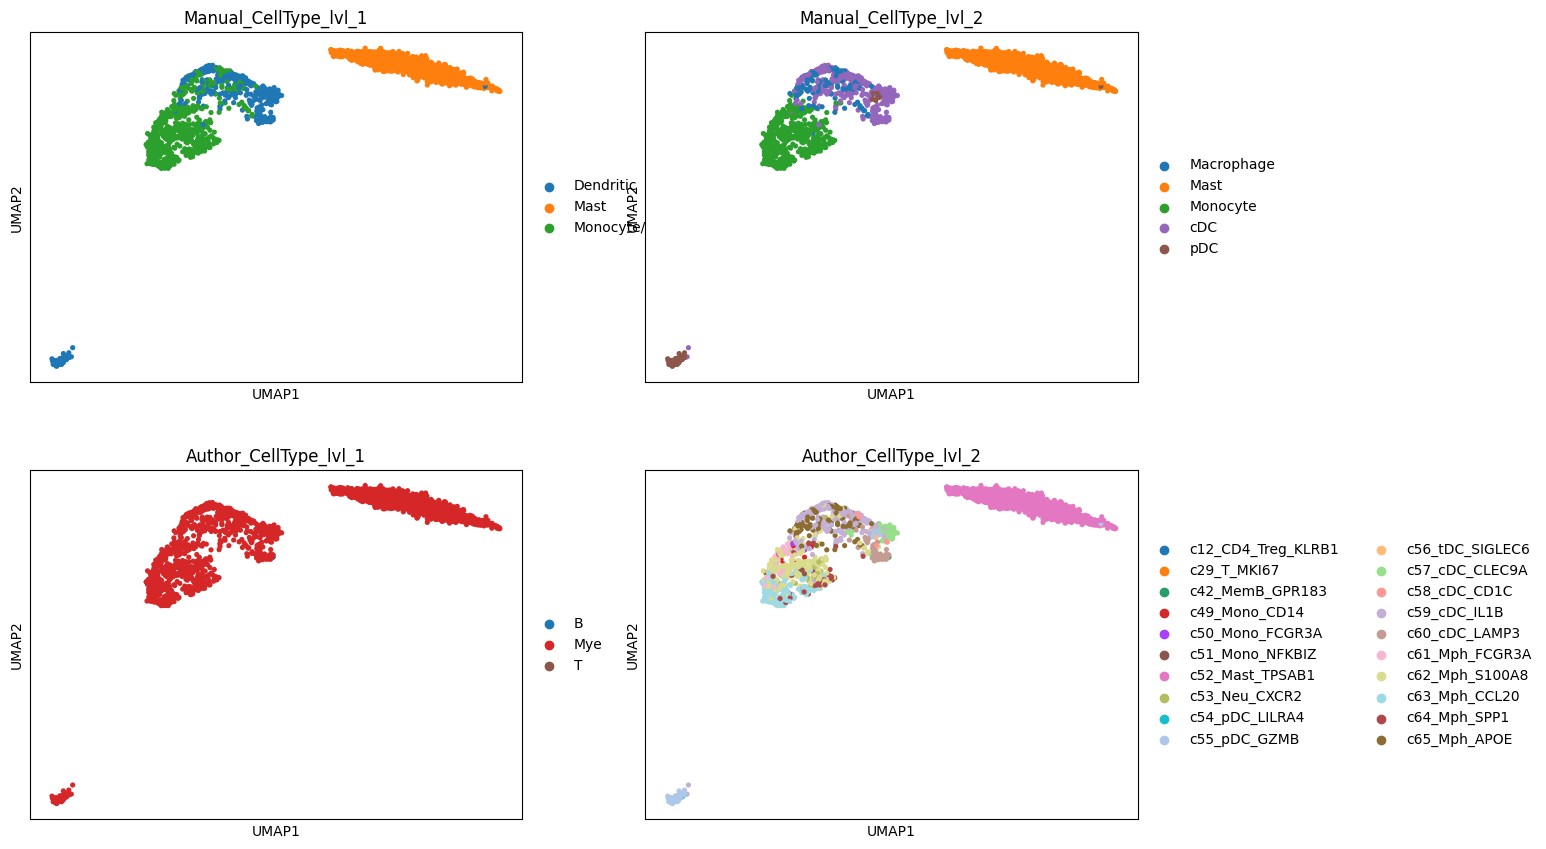

In [345]:
sc.pl.umap(adata_chen_TME[adata_chen_TME.obs['Manual_CellType_lvl_2']!='N/A'], color=['Manual_CellType_lvl_1', 'Manual_CellType_lvl_2', 
                                                                                      'Author_CellType_lvl_1', 'Author_CellType_lvl_2'], ncols=2)

## Epithelial cells

In [398]:
smillie_marker_converted = pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/Smillie_et_al/entrez_id_conversion/colon_epithelial_marker.ensembl_id.csv')
dict_InitialAlias_to_GeneName = { tup.initial_alias : tup.name for tup in smillie_marker_converted.itertuples() }

smillie_marker = pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/Smillie_et_al/colon_epithelial_marker.csv')
for gene in smillie_marker['gene']:
    try: dict_InitialAlias_to_GeneName[gene]
    except KeyError: dict_InitialAlias_to_GeneName[gene] = None
smillie_marker['gene'] = [ dict_InitialAlias_to_GeneName[gene] for gene in smillie_marker['gene'] ]
print(smillie_marker.shape[0])
smillie_marker.dropna(inplace=True)
print(smillie_marker.shape[0])
IntestinalEpiCellTypes = [ ident for ident in set(smillie_marker['ident']) if ident[:2] != 'E.' ]

3045
2666


In [373]:
adata_chen_epi = adata_chen_TME[adata_chen_TME.obs['leiden_res_0.1'].isin(['0', '5', '13'])].copy()
adata_chen_epi = adata_chen_epi.raw.to_adata()

In [374]:
sc.pp.normalize_total(adata_chen_epi)
sc.pp.log1p(adata_chen_epi)
sc.pp.highly_variable_genes(adata_chen_epi, n_top_genes=2000, batch_key="SampleID")

adata_chen_epi.raw = adata_chen_epi.copy()
adata_chen_epi = adata_chen_epi[:, adata_chen_epi.var.highly_variable]

sc.pp.scale(adata_chen_epi, max_value=10)
sc.tl.pca(adata_chen_epi, svd_solver="arpack")

sc.pp.neighbors(adata_chen_epi, n_neighbors=25, n_pcs=40)
sc.tl.umap(adata_chen_epi, random_state=42)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


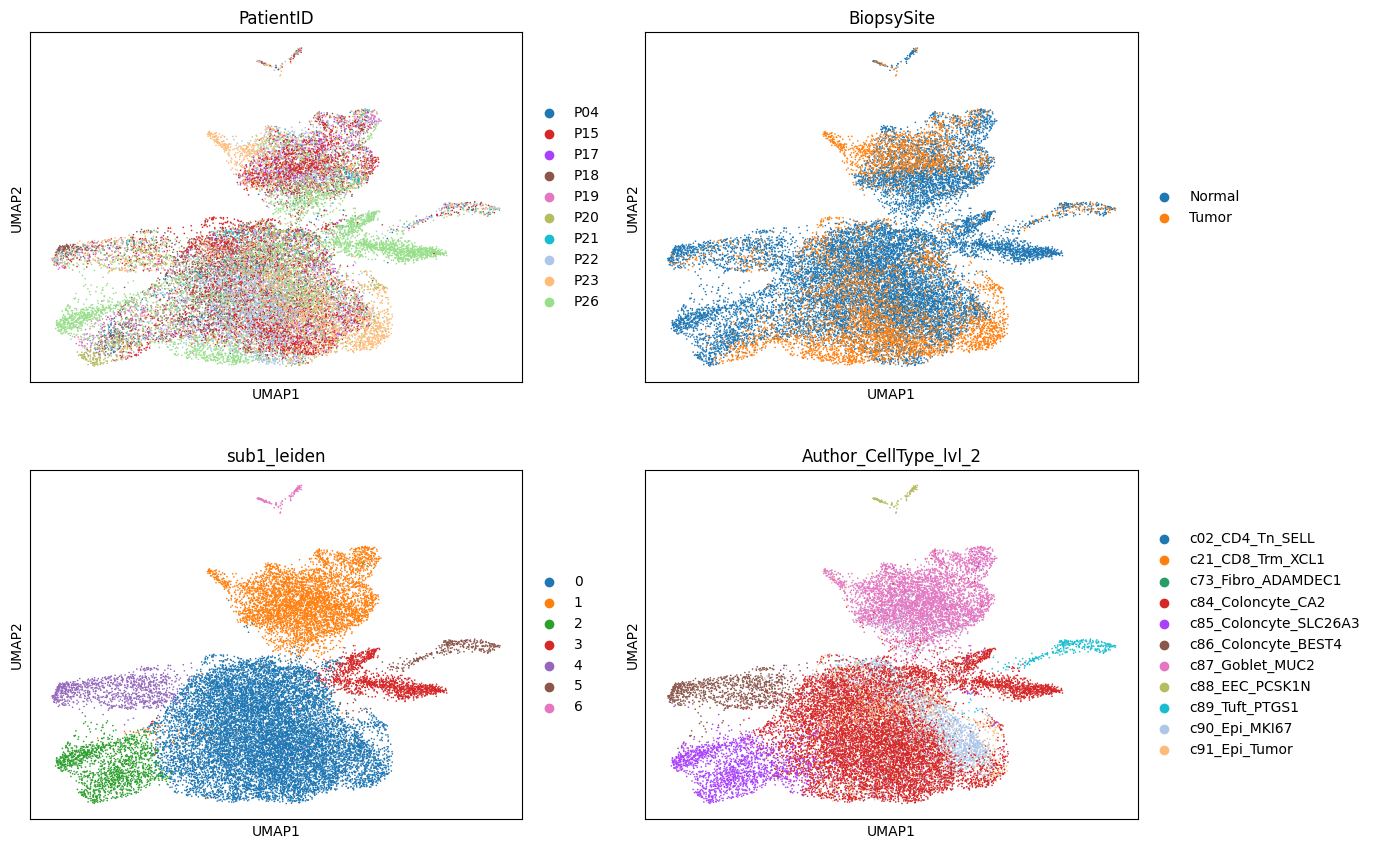

In [375]:
sc.tl.leiden(adata_chen_epi, resolution=0.2, key_added='sub1_leiden')
sc.pl.umap(adata_chen_epi, color=['PatientID', 'BiopsySite', 'sub1_leiden', 'Author_CellType_lvl_2'], ncols=2)

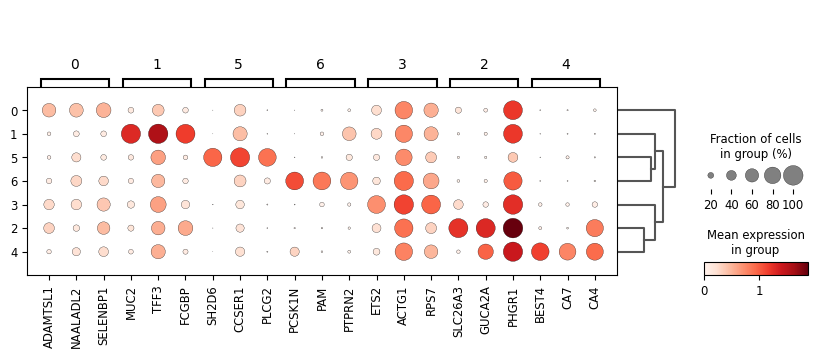

In [376]:
sc.tl.rank_genes_groups(adata_chen_epi, groupby='sub1_leiden', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata_chen_epi, n_genes=3, groupby='sub1_leiden')

### Overview using marker genes (Smillie et al.) 

In [ ]:
varIndex = adata_chen_epi.raw.to_adata().var.index 

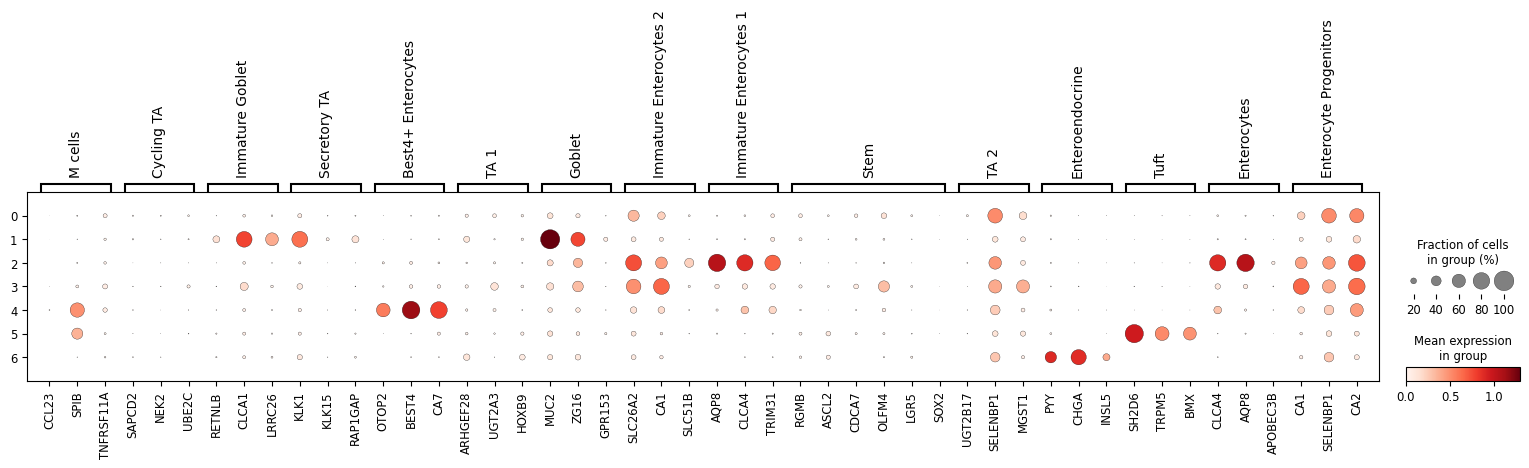

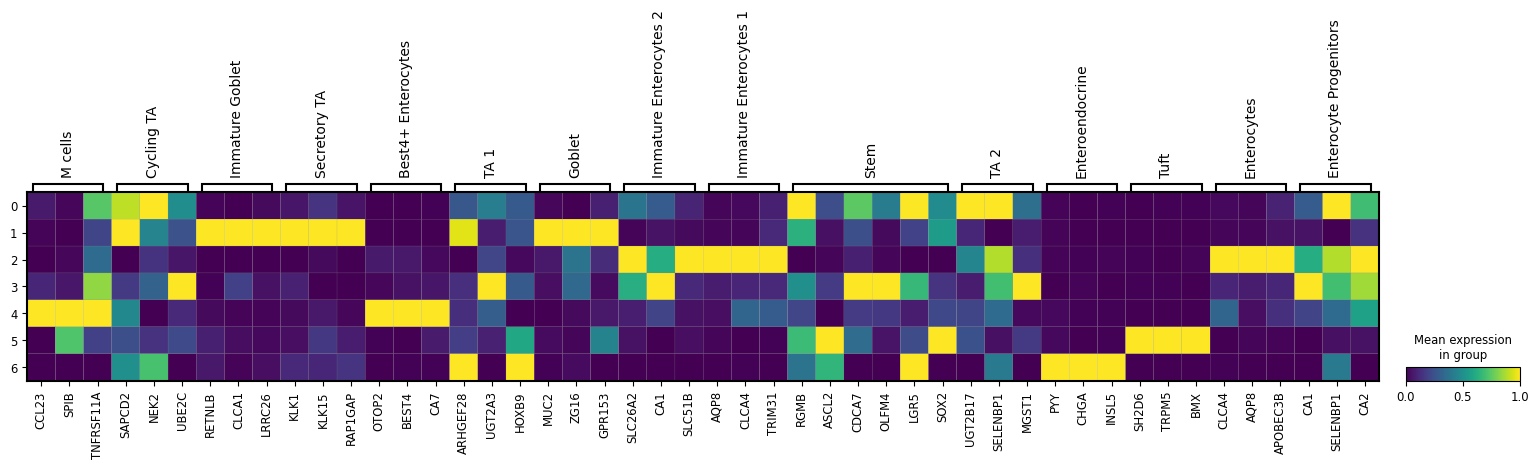

In [410]:
dict_ident_to_marker = dict()
n_genes = 3

for ident in IntestinalEpiCellTypes:
    top_n_genes = list() 
    for gene in smillie_marker[(smillie_marker['ident']==ident) & 
                               (smillie_marker['pvalD']<=0.01) & 
                               (smillie_marker['pvalC']<=0.01)].sort_values('log2fc', ascending=False)['gene']:
        if gene in varIndex:
            top_n_genes.append(gene)
            if len(top_n_genes) == n_genes: break
    
    dict_ident_to_marker[ident] = top_n_genes
    
dict_ident_to_marker['Stem'].append( 'OLFM4' )
dict_ident_to_marker['Stem'].append( 'LGR5' )
dict_ident_to_marker['Stem'].append( 'SOX2' )

sc.pl.dotplot( adata_chen_epi, var_names=dict_ident_to_marker, groupby='sub1_leiden', swap_axes=False, )
sc.pl.matrixplot( adata_chen_epi, var_names=dict_ident_to_marker, groupby='sub1_leiden', swap_axes=False, standard_scale='var')

### leiden 1: Goblet

In [569]:
for tup in adata_chen_epi[adata_chen_epi.obs['sub1_leiden'].isin(['1'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Epithelial'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'Goblet'

### leiden 5: Tuft 

In [570]:
for tup in adata_chen_epi[adata_chen_epi.obs['sub1_leiden'].isin(['5'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Epithelial'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'Tuft'

### leiden 6: Enteroendocrine

In [571]:
for tup in adata_chen_epi[adata_chen_epi.obs['sub1_leiden'].isin(['6'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Epithelial'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'Enteroendocrine'

### Subcluster other leidens

In [601]:
adata_chen_epi_subset = adata_chen_epi[adata_chen_epi.obs['sub1_leiden'].isin( ['0', '2', '3', '4',] )].copy()
adata_chen_epi_subset = adata_chen_epi_subset.raw.to_adata()

In [573]:
temp = list()
for SampleID, edf in adata_chen_epi_subset.obs.groupby('SampleID'):
    if len(edf) <= 1:
        print(SampleID, len(edf))
        temp.append( SampleID )
        dict_Identifier_to_lvl_1_CellType[edf.iloc[0].Identifier] = 'Epithelial'
        dict_Identifier_to_lvl_2_CellType[edf.iloc[0].Identifier] = 'N/A'

adata_chen_epi_subset = adata_chen_epi_subset[~(adata_chen_epi_subset.obs['SampleID'].isin(temp))].copy()

sc.pp.normalize_total(adata_chen_epi_subset)
sc.pp.log1p(adata_chen_epi_subset)
sc.pp.highly_variable_genes(adata_chen_epi_subset, n_top_genes=2000, batch_key="SampleID")

adata_chen_epi_subset.raw = adata_chen_epi_subset.copy()
adata_chen_epi_subset = adata_chen_epi_subset[:, adata_chen_epi_subset.var.highly_variable]

sc.pp.scale(adata_chen_epi_subset, max_value=10)
sc.tl.pca(adata_chen_epi_subset, svd_solver="arpack")

sc.pp.neighbors(adata_chen_epi_subset, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_chen_epi_subset, random_state=42)

/tmp/ipykernel_207941/3447071591.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for SampleID, edf in adata_chen_epi_subset.obs.groupby('SampleID'):


P17-T-I 1


/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [574]:
sc.tl.leiden(adata_chen_epi_subset, resolution=0.2, key_added='sub2_leiden')

In [575]:
for ident in IntestinalEpiCellTypes:
    sc.tl.score_genes(adata_chen_epi_subset, smillie_marker[(smillie_marker['pvalD']<=0.05) & (smillie_marker['pvalC']<=0.05) & (smillie_marker['ident']==ident)]['gene'], score_name=f'{ident}_score')

In [576]:
IntestinalEpiCellTypes

['M cells',
 'Cycling TA',
 'Immature Goblet',
 'Secretory TA',
 'Best4+ Enterocytes',
 'TA 1',
 'Goblet',
 'Immature Enterocytes 2',
 'Immature Enterocytes 1',
 'Stem',
 'TA 2',
 'Enteroendocrine',
 'Tuft',
 'Enterocytes',
 'Enterocyte Progenitors']

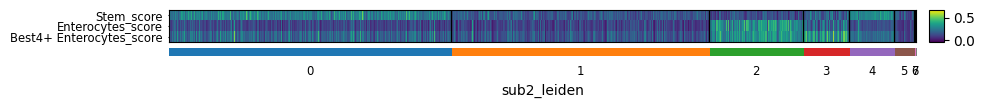

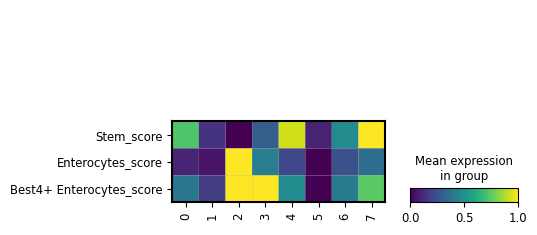

In [577]:
ioi = 'Tuft'
sc.pl.heatmap(adata_chen_epi_subset, groupby='sub2_leiden', var_names=['Stem_score', 'Enterocytes_score', 'Best4+ Enterocytes_score'], swap_axes=True)
sc.pl.matrixplot(adata_chen_epi_subset, groupby='sub2_leiden', var_names=['Stem_score', 'Enterocytes_score', 'Best4+ Enterocytes_score'], swap_axes=True, standard_scale='var')

In [578]:
sc.tl.rank_genes_groups(adata_chen_epi_subset, groupby='sub2_leiden', method='wilcoxon')

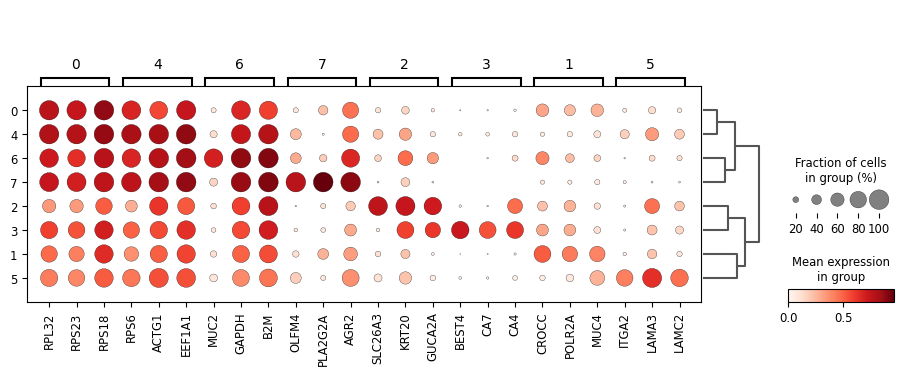

In [579]:
sc.pl.rank_genes_groups_dotplot(adata_chen_epi_subset, groupby='sub2_leiden', n_genes=3)

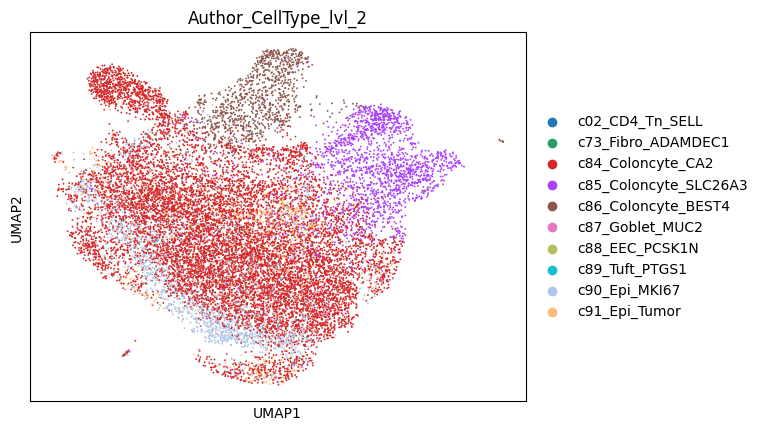

In [580]:
sc.pl.umap(adata_chen_epi_subset, color=['Author_CellType_lvl_2'])

#### leiden [0,2,3,4]-2: Enterocytes

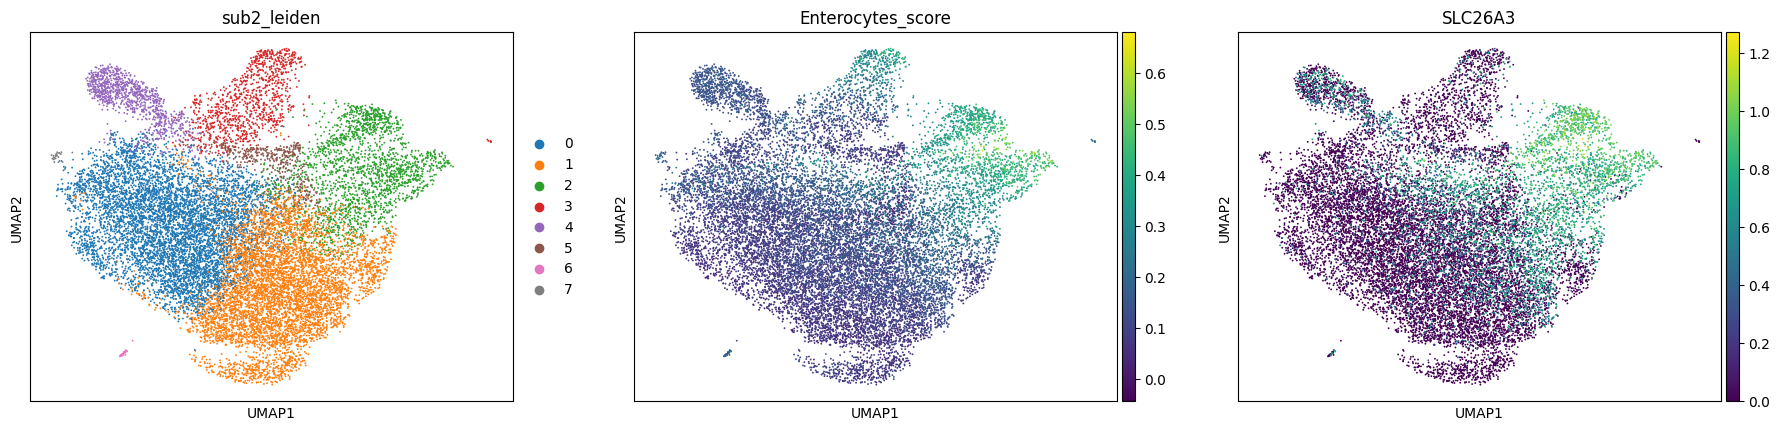

In [581]:
sc.pl.umap(adata_chen_epi_subset, color=['sub2_leiden', 'Enterocytes_score', 'SLC26A3'])

In [582]:
for tup in adata_chen_epi_subset[adata_chen_epi_subset.obs['sub2_leiden'].isin(['2'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Epithelial'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'Enterocytes'

#### leiden [0,2,3,4]-3: BEST4+ Enterocytes

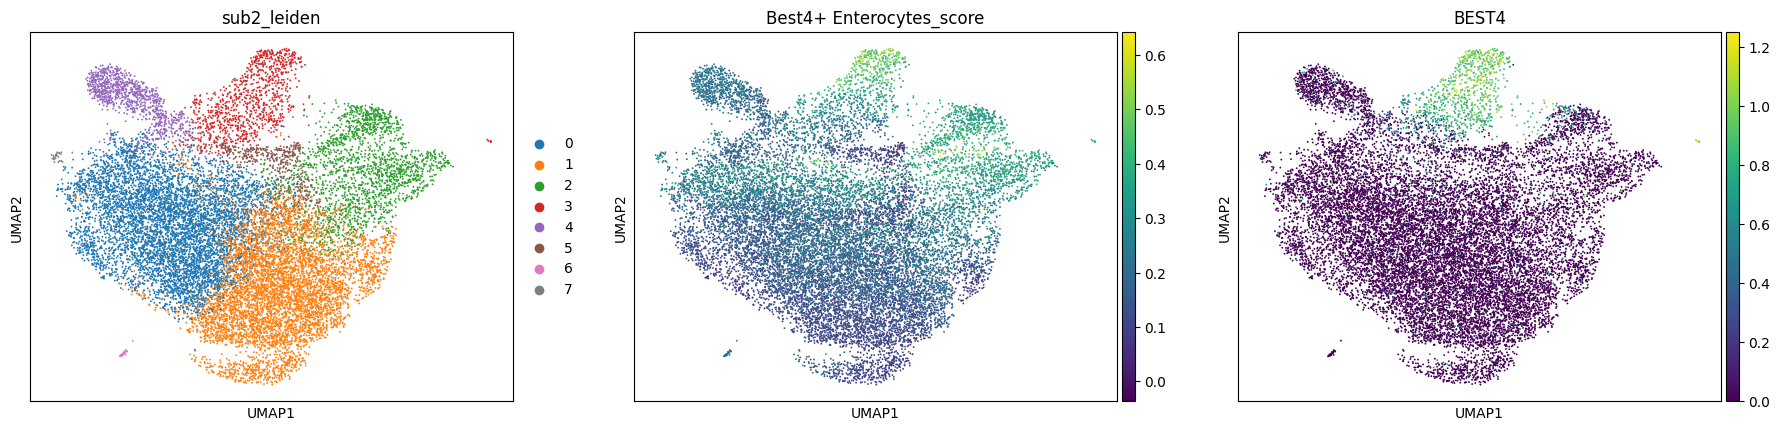

In [583]:
sc.pl.umap(adata_chen_epi_subset, color=['sub2_leiden', 'Best4+ Enterocytes_score', 'BEST4'])

In [584]:
for tup in adata_chen_epi_subset[adata_chen_epi_subset.obs['sub2_leiden'].isin(['3'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Epithelial'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'BEST4+ Enterocytes'

#### leiden [0,2,3,4]: Sub-subcluster

In [585]:
adata_chen_epi_subset_subset = adata_chen_epi_subset[~(adata_chen_epi_subset.obs['sub2_leiden'].isin(['2', '3']))].copy()
adata_chen_epi_subset_subset = adata_chen_epi_subset_subset.raw.to_adata()

In [586]:
sc.pp.normalize_total(adata_chen_epi_subset_subset)
sc.pp.log1p(adata_chen_epi_subset_subset)
# sc.pp.highly_variable_genes(adata_chen_epi_subset_subset, n_top_genes=2000, batch_key="SampleID")

adata_chen_epi_subset_subset.raw = adata_chen_epi_subset_subset.copy()
# adata_chen_epi_subset_subset = adata_chen_epi_subset_subset[:, adata_chen_epi_subset_subset.var.highly_variable]

smillie_marker_list = smillie_marker[(smillie_marker['pvalC']<=0.01) & (smillie_marker['pvalD']<=0.01) & ((smillie_marker['log2fc']>=2))]['gene']
print(len(smillie_marker_list))
adata_chen_epi_subset_subset = adata_chen_epi_subset_subset[:, adata_chen_epi_subset_subset.var.index.isin(smillie_marker_list)]

sc.pp.scale(adata_chen_epi_subset_subset, max_value=10)
sc.tl.pca(adata_chen_epi_subset_subset, svd_solver="arpack")

980


/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [587]:
sc.pp.neighbors(adata_chen_epi_subset_subset, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_chen_epi_subset_subset, random_state=42)

In [588]:
sc.tl.leiden(adata_chen_epi_subset_subset, resolution=0.5, key_added='sub3_leiden')

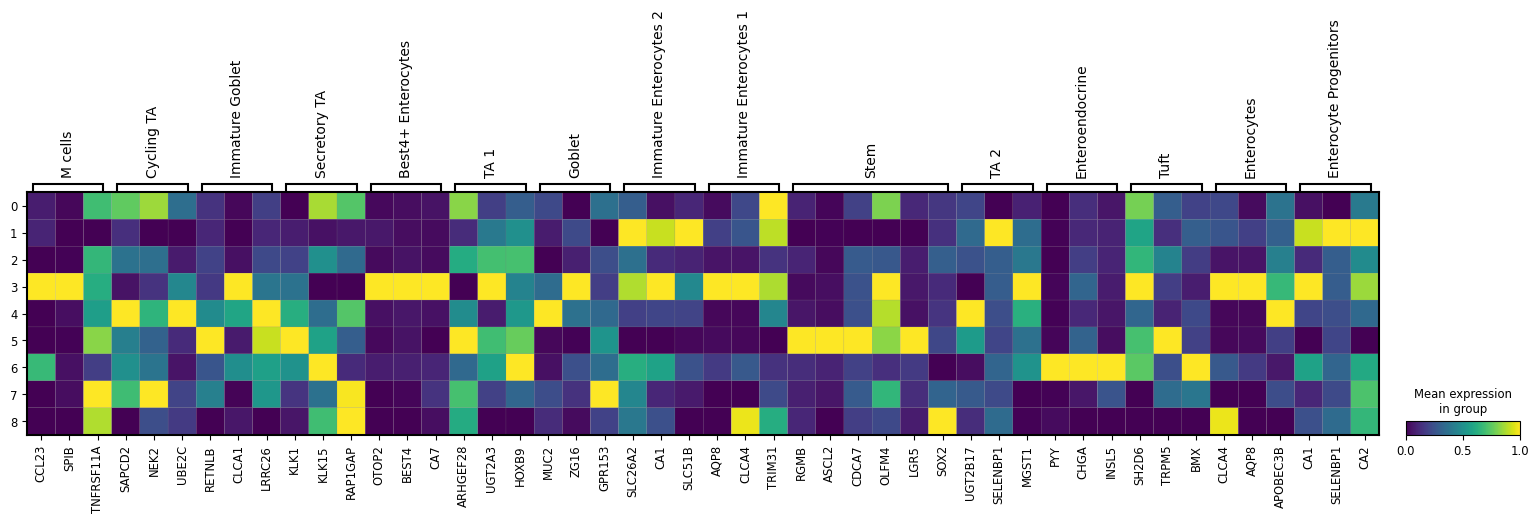

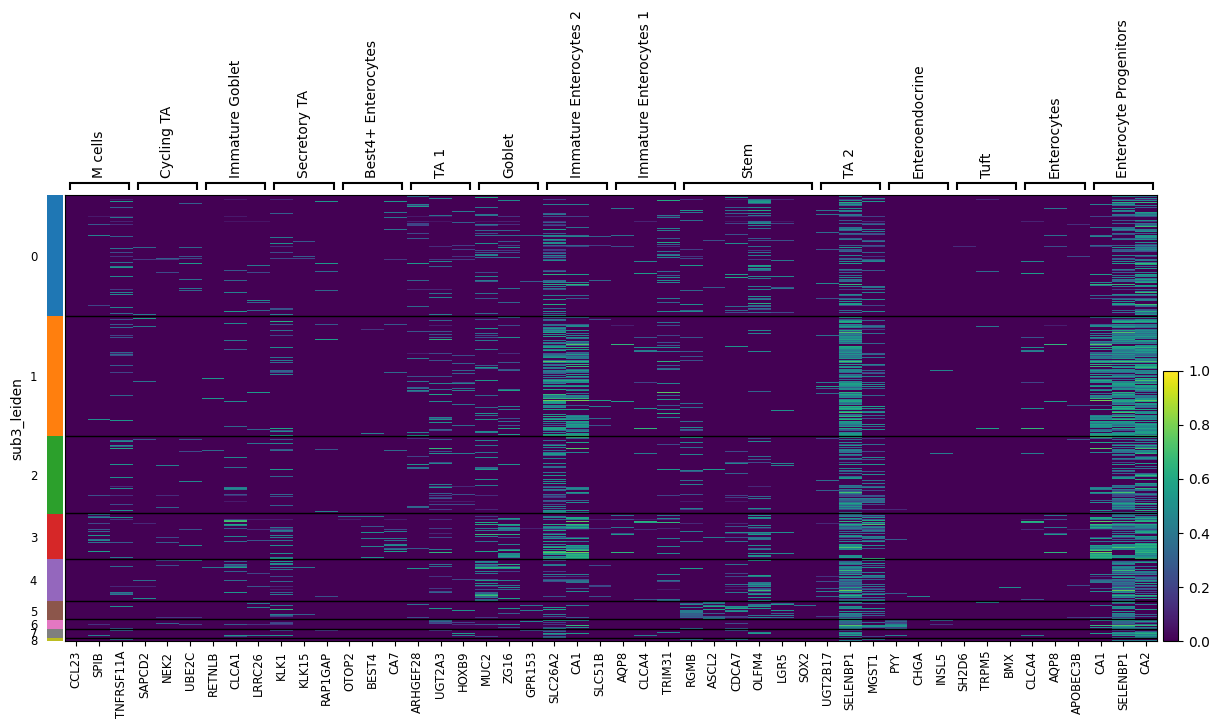

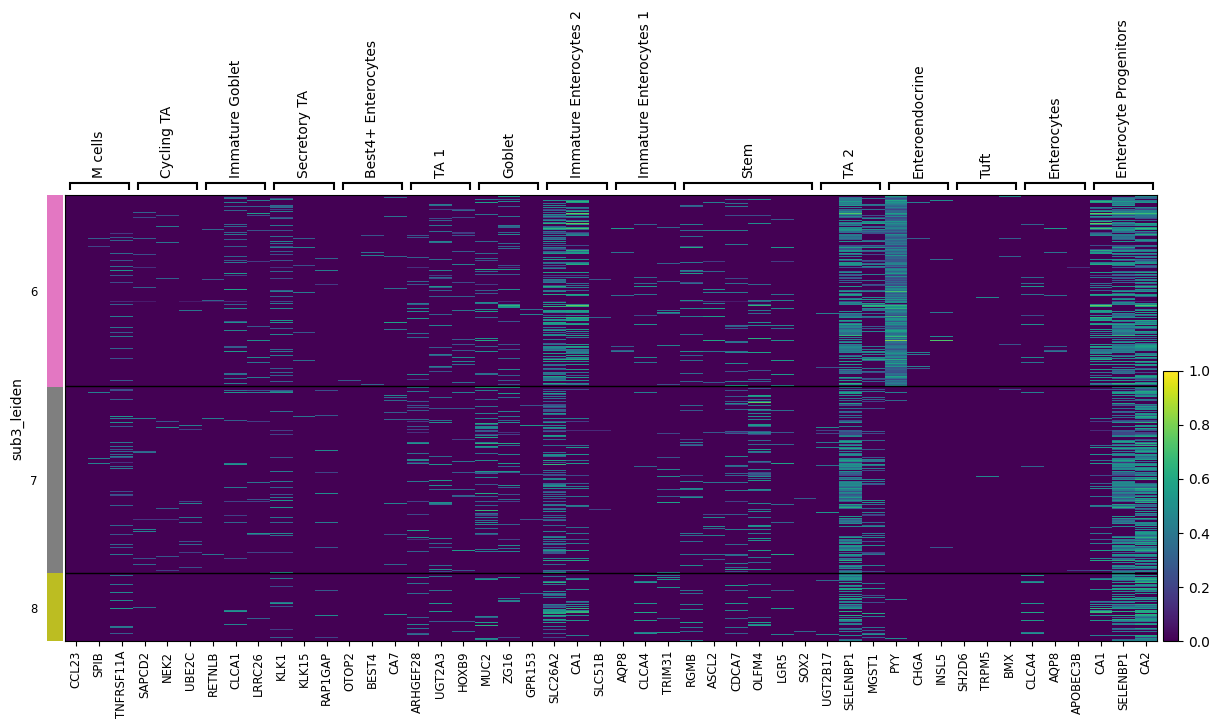

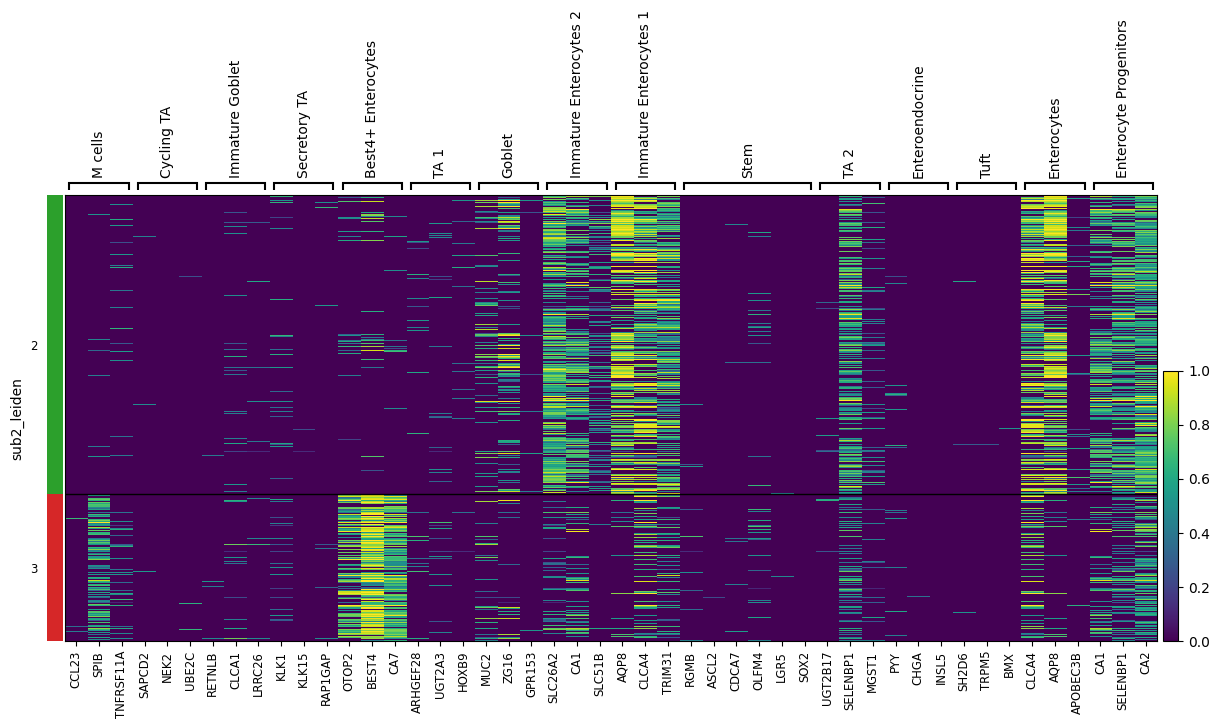

In [589]:
sc.pl.matrixplot( adata_chen_epi_subset_subset, var_names=dict_ident_to_marker, groupby='sub3_leiden', swap_axes=False, standard_scale='var')
sc.pl.heatmap( adata_chen_epi_subset_subset, var_names=dict_ident_to_marker, groupby='sub3_leiden', swap_axes=False, 
              vmax=1, vmin=0)
sc.pl.heatmap( adata_chen_epi_subset_subset[adata_chen_epi_subset_subset.obs['sub3_leiden'].isin(['6', '7', '8'])], 
              var_names=dict_ident_to_marker, groupby='sub3_leiden', swap_axes=False, 
              vmax=1, vmin=0)
sc.pl.heatmap( adata_chen_epi_subset[~(adata_chen_epi_subset.obs['Identifier'].isin( adata_chen_epi_subset_subset.obs['Identifier'] ))], 
              var_names=dict_ident_to_marker, 
              groupby='sub2_leiden', 
              swap_axes=False, vmax=1, vmin=0)

In [590]:
for tup in adata_chen_epi_subset_subset.obs.itertuples():
    if tup.sub3_leiden == '4':
        dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Epithelial'
        dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'Goblet'
    elif tup.sub3_leiden =='5':
        dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Epithelial'
        dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'Intestinal stem'
    else:
        dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Epithelial'
        dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'Enterocyte progenitors'

### Label & Inspect results

In [603]:
adata_chen_epi.obs['Manual_CellType_lvl_1'] = [ dict_Identifier_to_lvl_1_CellType[Identifier] for Identifier in adata_chen_epi.obs['Identifier'] ]
adata_chen_epi.obs['Manual_CellType_lvl_2'] = [ dict_Identifier_to_lvl_2_CellType[Identifier] for Identifier in adata_chen_epi.obs['Identifier'] ]

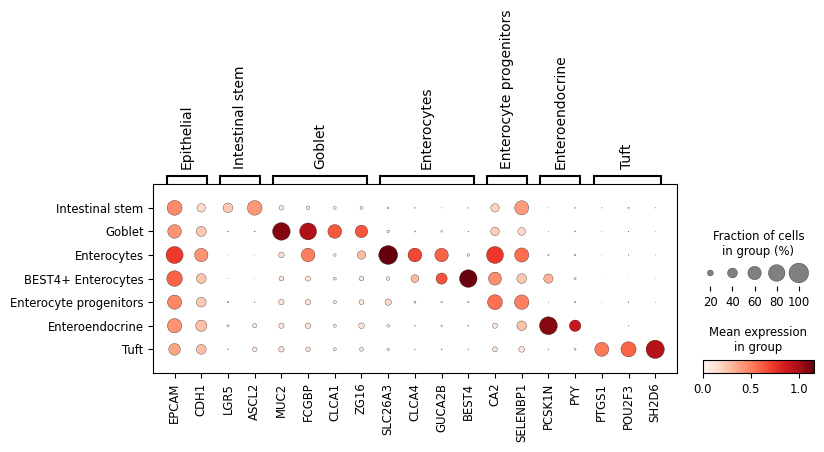

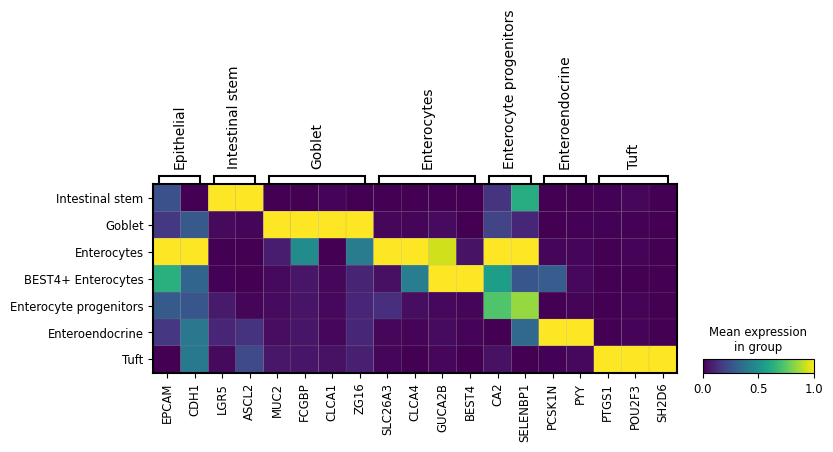

In [664]:
Epithelial_markers = { 'Epithelial' : ['EPCAM', 'CDH1', ], 
                         'Intestinal stem' : ['LGR5', 'ASCL2',], 
                         'Goblet' : ['MUC2', 'FCGBP', 'CLCA1', 'ZG16', ], 
                         'Enterocytes' : ['SLC26A3', 'CLCA4', 'GUCA2B', 'BEST4', ], 
                         'Enterocyte progenitors' : ['CA2', 'SELENBP1'], 
                         'Enteroendocrine' : ['PCSK1N', 'PYY'], 
                         'Tuft' : ['PTGS1', 'POU2F3', 'SH2D6',],}

sc.pl.dotplot(adata_chen_epi[adata_chen_epi.obs['Manual_CellType_lvl_2']!='N/A'], 
              var_names=Epithelial_markers, 
              groupby='Manual_CellType_lvl_2', 
              categories_order=['Intestinal stem', 'Goblet', 'Enterocytes', 
                                'BEST4+ Enterocytes', 'Enterocyte progenitors', 'Enteroendocrine', 
                                'Tuft'])

sc.pl.matrixplot(adata_chen_epi[adata_chen_epi.obs['Manual_CellType_lvl_2']!='N/A'], 
              var_names=Epithelial_markers, 
              groupby='Manual_CellType_lvl_2', 
              categories_order=['Intestinal stem', 'Goblet', 'Enterocytes', 
                                'BEST4+ Enterocytes', 'Enterocyte progenitors', 'Enteroendocrine', 
                                'Tuft'], 
              standard_scale='var',)

In [667]:
saveWithPickle(dict_Identifier_to_lvl_1_CellType, '/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType', 'Mye_and_Epi.lvl1')
saveWithPickle(dict_Identifier_to_lvl_2_CellType, '/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType', 'Mye_and_Epi.lvl2')